# Banana Navigation

In this notebook we will train a Deep Q-Network (DQN) Agent to navigate and collect certain kind of items (yellow banana) while avoiding another kind of items (blue banana) in a large square world.

In [1]:
import numpy as np
import torch
from dqn.agent import Agent
from unityagents import UnityEnvironment
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### Check for GPU device. If not available use CPU

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Create the environment and set the default for controlling
Please change the file name of the environment in case the file path or name is different

In [3]:
env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Check the environment for Action and State size

In [4]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]

In [5]:
action_size = brain.vector_action_space_size
state_size = len(state)

### Create an agent

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, device=device)

### Helper method to train the agent on the environment

**Parameters:**
- **n_episodes(int):** Maximum number of episodes to run the training process
- **max_t(int):** Maximum number of time step the agent will spend in each episode
- **eps_start(float):** Initial value of epsilon
- **eps_end(float):** Minimum value of epsilon
- **eps_decay(float):** The decay rate of epsilon for each episode
- **max_score(float):** The avg. score in last 100 episodes after which the environment will be considered as solved
- **model_path(str):** Path to save the trained model

In [7]:
def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, max_score=13.0, model_path='model.pt'):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps*eps_decay)
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window)}", end="")
        if i_episode % 100 == 0:
            print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window)}")
        if np.mean(scores_window) >= max_score:
            print(f"\nEnvironment solved in {i_episode-100} episodes!\tAverage Score: {np.mean(scores_window)}")
            torch.save(agent.qnetwork_local.state_dict(), model_path)
            break
    return scores

### Helper method to visualize the training scores

**Parameters**
- **scores(list of floats):** The scores collected for all episodes

In [8]:
def visualize(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Scores')
    plt.xlabel('Episode')
    plt.show()

### Helper method to test a trained agent on the environment

**Parameters**
- **env:** The environmnts
- **agent:** The agent object
- **n_episodes(int):** Number of episodes to run the test
- **model_path:** Path to a saved pytorch model 

In [10]:
def test(env, agent, n_episodes=3, model_path='model.pt'):
    agent.qnetwork_local.load_state_dict(torch.load(model_path))
    total_score = 0
    for i_episode in range(1, n_episodes+1):
        score = 0
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations[0]
        while True:
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            score += reward
            state = next_state
            if done:
                break
        print(f"\rEpisode {i_episode} \tScore: {score}")
        total_score += score
    print(f"\rAverage score in {n_episodes} episodes: {total_score/n_episodes}")
            

### Run the training process
Start training the agent and visualize the scores after the completion of the training. In case of any error close the environment.

Episode 100	Average Score: 0.476464646464646445
Episode 200	Average Score: 3.44
Episode 300	Average Score: 6.98
Episode 400	Average Score: 9.59
Episode 500	Average Score: 11.64
Episode 571	Average Score: 13.03
Environment solved in 471 episodes!	Average Score: 13.03


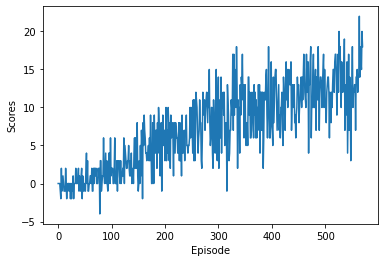

In [9]:
try:
    scores = train()
    visualize(scores)
except Exception as e:
    env.close()
    raise e

### Test the agent
Use the trained agent to play the game.

In [11]:
test(env=env, agent=agent)

Episode 1 	Score: 10.0
Episode 2 	Score: 12.0
Episode 3 	Score: 14.0
Average score in 3 episodes: 12.0


### Close the environment after everything is done

In [12]:
env.close()